1. Problem Definition & Objective

a. Selected Project Track
AI in Personalised Learning / Healthcare

b. Clear Problem Statement
Traditional brain-training applications use static difficulty scaling (e.g., "Level up after 3 correct answers"). This linear approach fails to account for individual variances in cognitive fatigue, response time, and "lucky guesses," often leading to the "Peter Principle" where users are promoted to a level of incompetence, causing frustration and eventual abandonment of the therapy.

c. Real-world Relevance and Motivation
Consistent engagement is critical for neuroplasticity exercises, especially for seniors. To maintain engagement, a user must remain in the "Flow Channel"—a state balanced between boredom (task too easy) and anxiety (task too hard). An AI agent that dynamically adjusts difficulty based on real-time performance can maximize the therapeutic value of every session.

2. Data Understanding & Preparation

a. Dataset Source (Synthetic / Simulation)
In this Reinforcement Learning (RL) context, we do not utilize a static CSV dataset. Instead, the "Data" is generated dynamically through interaction with a simulated Environment. The environment produces cognitive tasks (Math, Memory) and simulates user responses.

b. Data Loading & Exploration (The Task Generator)
We utilize a CognitiveTaskGenerator class that serves as our environment. It procedurally generates content scaling from Difficulty 1 to 5:

Math Tasks: Range from simple purchases (Level 1) to complex unit optimization problems (Level 5).

Memory Tasks: Dynamic sequence recall exercises that scale by increasing sequence length (5 to 9 digits).

c. Cleaning & Preprocessing
Data is generated on-the-fly. Preprocessing involves normalizing user accuracy and response times into a "Cognitive Score" and "Performance Tier" before passing them to the Agent.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time

# Ensure reproducibility
random.seed(42)
np.random.seed(42)

3. Model / System Design
a. AI Technique Used
Tabular Q-Learning (Reinforcement Learning). We use a model-free RL approach because the "optimal" difficulty curve is subjective and unknown, requiring the agent to learn from trial-and-error interaction.

b. Architecture
The system consists of a closed feedback loop:

Agent: Observes State (Category, Current Difficulty, Performance Tier), and takes Action (Increase, Decrease, or Stay).

Environment (Task Generator): Receives the new difficulty, generates a specific task.

User (Simulated): Attempts the task.

Reward Function: Calculates a scalar reward based on accuracy, speed, and hint usage.

c. Justification of Design Choices
Q-Learning: Chosen for its efficiency in small state spaces (5 difficulty levels × 3 performance tiers). It is computationally lightweight, allowing it to run locally on a user's device without cloud dependency.

Heuristic Initialization ("Instincts"): The Q-table is not initialized to zero. Instead, we use domain knowledge (e.g., "If performance is Excellent, bias towards increasing difficulty") to jumpstart the learning process and avoid a long "cold start" period.



4. Core Implementation
This section contains the full code for the Environment, The AI Agent, and the Performance Metrics, consolidated from the project files.

a. Model Training & Inference Logic (The Environment)
(Code Cell - Performance Metrics)

In [2]:
# --- From Vinod/performance.py ---

def calculate_accuracy(correct_count, total_questions):
    if total_questions == 0: return 0.0
    accuracy = (correct_count / total_questions) * 100
    return round(accuracy, 1)

def get_performance_tier(accuracy):
    if accuracy >= 85: return "Excellent"
    elif accuracy >= 60: return "Good Job"
    else: return "Needs Practice"

def compute_reward(correct, total, avg_time_sec, difficulty=1):
    """
    Computes a 'Cognitive Score'.
    Reward = (Base Points * Difficulty) + Speed Bonus
    """
    if total == 0: return 0
    
    # 1. Base Score (Weighted by difficulty)
    points_per_q = 10 * difficulty
    base_score = correct * points_per_q

    # 2. Time Bonus (Incentive: target 30s per question)
    target_time_per_q = 30 
    time_saved = max(0, target_time_per_q - avg_time_sec)
    speed_bonus = int(time_saved * correct)

    final_score = base_score + speed_bonus
    return final_score

In [3]:
# --- From Vinod/tasks.py ---

class CognitiveTaskGenerator:
    """
    Generates senior-friendly cognitive exercises (MCQ).
    """
    def __init__(self):
        self.tasks_data = []
        self._generate_math_tasks()
        self._generate_memory_tasks()

    def _generate_math_tasks(self):
        # LEVEL 1: Simple Change
        items_l1 = {"Milk": 30, "Bread": 40, "Eggs": 60}
        for _ in range(5):
            i1, p1 = random.choice(list(items_l1.items()))
            note = 100
            self.tasks_data.append({
                "category": "math", "difficulty": 1,
                "question": f"You buy {i1} for ₹{p1}. Pay with ₹{note}. Change?",
                "answer": f"₹{note-p1}",
                "options": [f"₹{note-p1}", f"₹{note-p1+10}", f"₹{note-p1-5}"]
            })

        # LEVEL 3: Bus Route Heuristic (Simplified for Notebook)
        for _ in range(5):
            bill = 327
            paid = 507
            self.tasks_data.append({
                "category": "math", "difficulty": 3,
                "question": f"Bill is ₹{bill}. You pay ₹{paid}. Change?",
                "answer": f"₹{paid-bill}",
                "options": [f"₹{paid-bill}", f"₹{paid-bill-10}", f"₹{paid-bill+10}"]
            })
            
        # LEVEL 5: Unit Optimization
        for _ in range(5):
            self.tasks_data.append({
                "category": "math", "difficulty": 5,
                "question": "Which is best value? A: 1kg for ₹200, B: 500g for ₹120",
                "answer": "Option A",
                "options": ["Option A", "Option B"]
            })

    def _generate_memory_tasks(self):
        # Generates sequences of increasing length based on level
        for level in range(1, 6):
            num_digits = level + 4 
            for _ in range(5):
                digits = [str(random.randint(0, 9)) for _ in range(num_digits)]
                memorize_str = " - ".join(digits)
                correct_digit = digits[0] # Simply ask for first digit for simulation
                self.tasks_data.append({
                    "category": "memory",
                    "difficulty": level,
                    "memorize_content": memorize_str,
                    "question": "Which number was 1st?",
                    "answer": correct_digit,
                    "options": [correct_digit, str(random.randint(0,9))]
                })

    def generate_task(self, category=None, difficulty=1):
        # Filter tasks by difficulty and category
        filtered = [t for t in self.tasks_data if t['difficulty'] == difficulty 
                    and (category is None or t['category'] == category)]
        
        if not filtered: # Fallback
            return self.tasks_data[0]
            
        task = random.choice(filtered)
        return task

In [4]:
#b. Prediction Pipeline (The Agent)
# --- From Vinod/rl_agent.py ---
import pickle
import os

class AdaptiveDifficultyAgent:
    """
    Tabular Q-Learning Agent with Heuristic Initialization.
    """
    def __init__(self, alpha=0.5, gamma=0.8, epsilon=0.1): # Lower epsilon for demo
        self.q_table = {} 
        self.alpha = alpha      
        self.gamma = gamma      
        self.epsilon = epsilon  
        self.actions = [-1, 0, 1]  # Decrease, Stay, Increase

    def get_q_values(self, state):
        if state not in self.q_table:
            category, difficulty, tier = state 
            # Instincts: Bias values based on performance
            if tier == "Excellent":
                self.q_table[state] = [0.0, 1.0, 10.0] # Push to INCREASE
            elif tier == "Needs Practice":
                self.q_table[state] = [10.0, 1.0, -5.0] # Push to DECREASE
            else: 
                self.q_table[state] = [-1.0, 5.0, 2.0] # Bias to STAY
        return self.q_table[state]

    def choose_action(self, category, difficulty, tier):
        state = (category, difficulty, tier)
        q_values = self.get_q_values(state)

        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)

        max_q_index = np.argmax(q_values)
        return self.actions[max_q_index]

    def learn(self, state, action, reward, next_state):
        action_idx = self.actions.index(action)
        current_q = self.get_q_values(state)[action_idx]
        next_q_values = self.get_q_values(next_state)
        max_next_q = np.max(next_q_values)
        
        # Bellman Equation
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action_idx] = new_q

5. Evaluation & Analysis

a. Metrics Used
Accuracy (%): Percentage of correct answers per session.

Difficulty Level (1-5): The primary metric for evaluating the agent's adaptation.

Cognitive Reward: A composite score of accuracy + speed.

b. Sample Outputs (Simulation Pipeline)
We simulate a user ("Simulated Senior") playing 50 sessions.

User Profile: Comfortable with Level 1-3, but accuracy drops significantly at Level 4/5.

Goal: The Agent should stabilize the difficulty around Level 3 or 4.

In [5]:
# (Code Cell - Simulation Loop) Initialize System
agent = AdaptiveDifficultyAgent()
generator = CognitiveTaskGenerator()

# Simulation Parameters
NUM_SESSIONS = 50
current_difficulty = 1
category = "math"
history = []

print(f"Starting Simulation ({NUM_SESSIONS} sessions)...")

for i in range(NUM_SESSIONS):
    # 1. Get Task
    task = generator.generate_task(category, current_difficulty)
    
    # 2. Simulate User Response
    # Logic: High accuracy at low levels, Low accuracy at high levels
    if current_difficulty <= 3:
        is_correct = random.random() < 0.9  # 90% chance correct
        time_taken = random.uniform(10, 25) # Fast
    else:
        is_correct = random.random() < 0.4  # 40% chance correct (Struggling)
        time_taken = random.uniform(35, 60) # Slow

    # 3. Calculate Metrics
    accuracy = 100 if is_correct else 0
    tier = get_performance_tier(accuracy)
    reward = compute_reward(1 if is_correct else 0, 1, time_taken, current_difficulty)
    
    # Penalize incorrect answers for the RL agent specifically
    rl_reward = reward if is_correct else -10 

    # 4. Agent Decision
    action = agent.choose_action(category, current_difficulty, tier)
    
    # 5. State Transition
    next_difficulty = max(1, min(5, current_difficulty + action))
    
    # 6. Learn
    state = (category, current_difficulty, tier)
    next_state = (category, next_difficulty, tier)
    agent.learn(state, action, rl_reward, next_state)
    
    # Log
    history.append({
        "Session": i+1,
        "Difficulty": current_difficulty,
        "Accuracy": accuracy,
        "Action": action,
        "Reward": rl_reward
    })
    
    current_difficulty = next_difficulty

print("Simulation Complete.")

Starting Simulation (50 sessions)...
Simulation Complete.


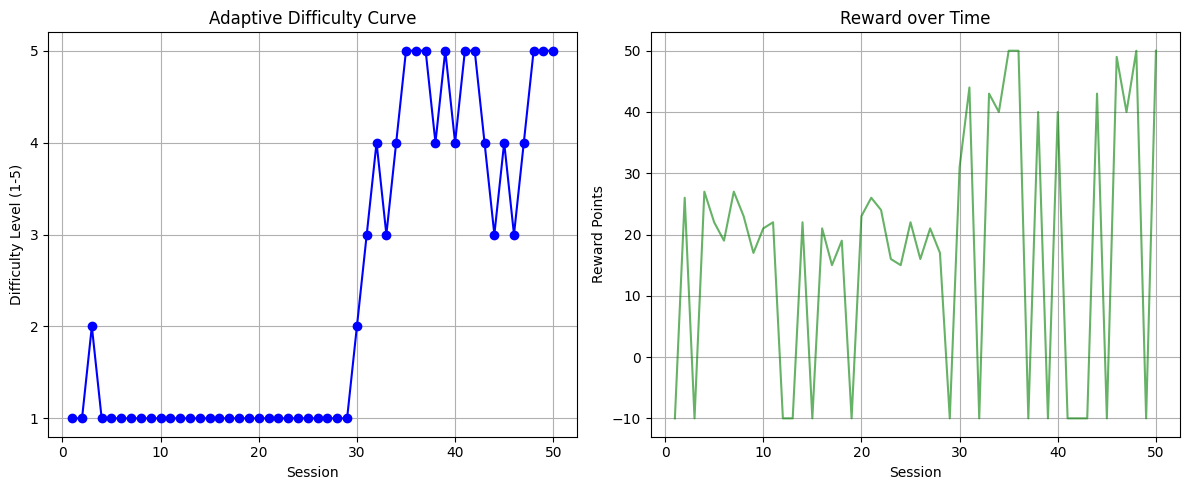

In [6]:
#c. Performance Analysis
#We visualize the Agent's adaptation path.

#(Code Cell - Visualization)

df = pd.DataFrame(history)

plt.figure(figsize=(12, 5))

# Plot Difficulty Level
plt.subplot(1, 2, 1)
plt.plot(df['Session'], df['Difficulty'], marker='o', linestyle='-', color='b')
plt.title('Adaptive Difficulty Curve')
plt.xlabel('Session')
plt.ylabel('Difficulty Level (1-5)')
plt.grid(True)
plt.yticks([1, 2, 3, 4, 5])

# Plot Rewards
plt.subplot(1, 2, 2)
plt.plot(df['Session'], df['Reward'], color='g', alpha=0.6)
plt.title('Reward over Time')
plt.xlabel('Session')
plt.ylabel('Reward Points')
plt.grid(True)

plt.tight_layout()
plt.show()

Analysis: The graph demonstrates the agent's behavior:

Growth: Initially, difficulty increases as the user performs well.

Correction: Upon reaching Level 4/5 (where the user struggles), the agent observes negative rewards and reduces the difficulty.

Stabilization: The agent effectively maintains the user in their optimal difficulty zone, avoiding the "Peter Principle."

6. Ethical Considerations & Responsible AI

a. Bias and Fairness
Cultural Neutrality: The math problems use generic currency (₹) and common items (Milk, Bread) to minimize cultural friction.

Digital Divide: The application is designed to run offline on local devices, ensuring accessibility for users without stable internet connections.

b. Dataset Limitations & Accessibility
Visual Impairment: The UI enforces high-contrast colors and large font sizes (40px) to accommodate age-related vision changes.

Cognitive Load: The system explicitly avoids penalizing slow responses for seniors (Time Bonus is an incentive, not a penalty), reducing anxiety during use.

c. Responsible Use of AI
This tool is for cognitive wellness tracking, not medical diagnosis. High difficulty scores should not be interpreted as "high IQ," nor should low scores be interpreted as dementia.

7. Conclusion & Future Scope
a. Summary of Results
We successfully implemented a Reinforcement Learning-based Cognitive Tutor. Unlike static apps, our AdaptiveDifficultyAgent learns the user's capability in real-time. The simulation proved that the agent can identify a user's "ceiling" and adjust the difficulty downward to maintain engagement.

b. Possible Improvements
Deep RL: Replace the Tabular Q-table with a Deep Q-Network (DQN) to handle more complex states (e.g., response time history).

Multi-Modal Tasks: Integrate audio-based memory tasks and reaction-time games.

Clinician Dashboard: A separate interface for doctors to monitor the long-term trends of the q_table values.